<a href="https://colab.research.google.com/github/Meddebma/pyradiomics/blob/master/Spleen0221.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setup environment**

In [1]:
%pip install monai
%pip install 'monai[nibabel, skimage, pillow, tensorboard, gdown, ignite, torchvision, itk, tqdm, lmdb, psutil]'
%pip install matplotlib
%pip install -q pytorch-lightning==0.9.0
%matplotlib inline

     |████████████████████████████████| 358kB 18.3MB/s 
     |████████████████████████████████| 184kB 16.3MB/s 
     |████████████████████████████████| 81kB 10.8MB/s 
     |████████████████████████████████| 10.3MB 24.6MB/s 
     |████████████████████████████████| 50.1MB 60kB/s 
     |████████████████████████████████| 68.0MB 45kB/s 
     |████████████████████████████████| 14.0MB 251kB/s 
     |████████████████████████████████| 14.4MB 248kB/s 
     |████████████████████████████████| 36.3MB 85kB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
     |████████████████████████████████| 409kB 16.0MB/s 
     |████████████████████████████████| 2.8MB 35.9MB/s 
     |████████████████████████████████| 829kB 49.4MB/s 
     |████████████████████████████████| 645kB 49.6MB/s 
ERROR: tensorflow 2.4.1 has requirement tensorboard~=2.4, but you'll have tensorboard 2.2.0 which is incompatible.


**Setup imports**

In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from monai.utils import set_determinism
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import compute_meandice, compute_roc_auc
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, list_data_collate
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import pytorch_lightning
from pytorch_lightning.callbacks.model_checkpoint \
    import ModelCheckpoint
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import sys
from glob import glob

print_config()

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


MONAI version: 0.4.0
Numpy version: 1.19.5
Pytorch version: 1.7.1+cu101
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0563a4467fa602feca92d91c7f47261868d171a1

Optional dependencies:
Pytorch Ignite version: 0.4.2
Nibabel version: 3.0.2
scikit-image version: 0.16.2
Pillow version: 7.0.0
Tensorboard version: 2.2.0
gdown version: 3.6.4
TorchVision version: 0.8.2+cu101
ITK version: 5.1.2
tqdm version: 4.59.0
lmdb version: 0.99
psutil version: 5.4.8

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
data_dir= "/content/drive/My Drive/Task09_Spleen/"


**Define the LightningModule**

The LightningModule contains a refactoring of your training code.

In [4]:
class Net(pytorch_lightning.LightningModule):
    def __init__(self):
        super().__init__()
        self._model = UNet(
            dimensions=3,
            in_channels=1,
            out_channels=2,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2,
        )
        self.loss_function = DiceLoss(to_onehot_y=True, softmax=True)
        self.post_pred = AsDiscrete(argmax=True, to_onehot=True, n_classes=2)
        self.post_label = AsDiscrete(to_onehot=True, n_classes=2)
        self.best_val_dice = 0
        self.best_val_epoch = 0

    def forward(self, x):
        return self._model(x)

    def prepare_data(self):
        # set up the correct data path
        train_images = sorted(
            glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
        train_labels = sorted(
            glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
        data_dicts = [
            {"image": image_name, "label": label_name}
            for image_name, label_name in zip(train_images, train_labels)
        ]
        train_files, val_files = data_dicts[:-9], data_dicts[-9:]

        # set deterministic training for reproducibility
        set_determinism(seed=0)

        # define the data transforms
        train_transforms = Compose(
            [
                LoadImaged(keys=["image", "label"]),
                AddChanneld(keys=["image", "label"]),
                Spacingd(
                    keys=["image", "label"],
                    pixdim=(1.5, 1.5, 2.0),
                    mode=("bilinear", "nearest"),
                ),
                Orientationd(keys=["image", "label"], axcodes="RAS"),
                ScaleIntensityRanged(
                    keys=["image"], a_min=-57, a_max=164,
                    b_min=0.0, b_max=1.0, clip=True,
                ),
                CropForegroundd(keys=["image", "label"], source_key="image"),
                # randomly crop out patch samples from
                # big image based on pos / neg ratio
                # the image centers of negative samples
                # must be in valid image area
                RandCropByPosNegLabeld(
                    keys=["image", "label"],
                    label_key="label",
                    spatial_size=(96, 96, 96),
                    pos=1,
                    neg=1,
                    num_samples=4,
                    image_key="image",
                    image_threshold=0,
                ),
                # user can also add other random transforms
                #                 RandAffined(
                #                     keys=['image', 'label'],
                #                     mode=('bilinear', 'nearest'),
                #                     prob=1.0,
                #                     spatial_size=(96, 96, 96),
                #                     rotate_range=(0, 0, np.pi/15),
                #                     scale_range=(0.1, 0.1, 0.1)),
                ToTensord(keys=["image", "label"]),
            ]
        )
        val_transforms = Compose(
            [
                LoadImaged(keys=["image", "label"]),
                AddChanneld(keys=["image", "label"]),
                Spacingd(
                    keys=["image", "label"],
                    pixdim=(1.5, 1.5, 2.0),
                    mode=("bilinear", "nearest"),
                ),
                Orientationd(keys=["image", "label"], axcodes="RAS"),
                ScaleIntensityRanged(
                    keys=["image"], a_min=-57, a_max=164,
                    b_min=0.0, b_max=1.0, clip=True,
                ),
                CropForegroundd(keys=["image", "label"], source_key="image"),
                ToTensord(keys=["image", "label"]),
            ]
        )

        # we use cached datasets - these are 10x faster than regular datasets
        self.train_ds = CacheDataset(
            data=train_files, transform=train_transforms,
            cache_rate=1.0, num_workers=4,
        )
        self.val_ds = CacheDataset(
            data=val_files, transform=val_transforms,
            cache_rate=1.0, num_workers=4,
        )
#         self.train_ds = monai.data.Dataset(
#             data=train_files, transform=train_transforms)
#         self.val_ds = monai.data.Dataset(
#             data=val_files, transform=val_transforms)

    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(
            self.train_ds, batch_size=2, shuffle=True,
            num_workers=4, collate_fn=list_data_collate,
        )
        return train_loader

    def val_dataloader(self):
        val_loader = torch.utils.data.DataLoader(
            self.val_ds, batch_size=1, num_workers=4)
        return val_loader

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self._model.parameters(), 1e-4)
        return optimizer

    def training_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["label"]
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        tensorboard_logs = {"train_loss": loss.item()}
        return {"loss": loss, "log": tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["label"]
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        outputs = sliding_window_inference(
            images, roi_size, sw_batch_size, self.forward)
        loss = self.loss_function(outputs, labels)
        outputs = self.post_pred(outputs)
        labels = self.post_label(labels)
        value = compute_meandice(
            y_pred=outputs,
            y=labels,
            include_background=False,
        )
        return {"val_loss": loss, "val_dice": value}

    def validation_epoch_end(self, outputs):
        val_dice, val_loss, num_items = 0, 0, 0
        for output in outputs:
            val_dice += output["val_dice"].sum().item()
            val_loss += output["val_loss"].sum().item()
            num_items += len(output["val_dice"])
        mean_val_dice = torch.tensor(val_dice / num_items)
        mean_val_loss = torch.tensor(val_loss / num_items)
        tensorboard_logs = {
            "val_dice": mean_val_dice,
            "val_loss": mean_val_loss,
        }
        if mean_val_dice > self.best_val_dice:
            self.best_val_dice = mean_val_dice
            self.best_val_epoch = self.current_epoch
            torch.save(self._model.state_dict(), "/content/drive/My Drive/Task09_Spleen/best_metric_model_21.pth")
        print(
            f"current epoch: {self.current_epoch} "
            f"current mean dice: {mean_val_dice:.4f}"
            f"\nbest mean dice: {self.best_val_dice:.4f} "
            f"at epoch: {self.best_val_epoch}"
        )
        return {"log": tensorboard_logs}

In [5]:
import nibabel as nib
train_images = sorted(
            glob(os.path.join(data_dir, "imagestx", "*.nii.gz")))
train_labels = sorted(
            glob(os.path.join(data_dir, "labelstx", "*.nii.gz")))
for i in train_images:
  img = nib.load(i)
  print("images", img.shape)
for i in train_labels:
  img = nib.load(i)
  print("labels", img.shape)

images (512, 512, 85)
images (512, 512, 145)
images (512, 512, 162)
images (512, 512, 156)
images (512, 512, 161)
images (512, 512, 149)
images (512, 512, 127)
images (512, 512, 157)
images (512, 512, 165)
labels (512, 512, 85)
labels (512, 512, 145)
labels (512, 512, 162)
labels (512, 512, 156)
labels (512, 512, 161)
labels (512, 512, 149)
labels (512, 512, 127)
labels (512, 512, 157)
labels (512, 512, 165)


**Run the training**

In [7]:
root_dir = "/content/drive/My Drive/Task09_Spleen/"
# initialise the LightningModule
net = Net()

# set up loggers and checkpoints
log_dir = os.path.join(root_dir, "logs")
tb_logger = pytorch_lightning.loggers.TensorBoardLogger(
    save_dir=log_dir
)
checkpoint_callback = ModelCheckpoint(
    filepath= os.path.join(
        log_dir, "{epoch}-{val_loss:.2f}-{val_dice:.2f}")
)

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    gpus=[0],
    max_epochs=90,
    logger=tb_logger,
    checkpoint_callback=checkpoint_callback,
    num_sanity_val_steps=1,
)

# train
trainer.fit(net)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
100%|██████████| 9/9 [00:19<00:00,  2.22s/it]
Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given

  | Name          | Type     | Params
-------------------------------------------
0 | _model        | UNet     | 4 M   
1 | loss_function | DiceLoss | 0     


Validation sanity check: 0it [00:00, ?it/s]

current epoch: 0 current mean dice: 0.0079
best mean dice: 0.0079 at epoch: 0


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

current epoch: 0 current mean dice: 0.0269
best mean dice: 0.0269 at epoch: 0


Validating: 0it [00:00, ?it/s]

current epoch: 1 current mean dice: 0.0321
best mean dice: 0.0321 at epoch: 1


Validating: 0it [00:00, ?it/s]

current epoch: 2 current mean dice: 0.0438
best mean dice: 0.0438 at epoch: 2


Validating: 0it [00:00, ?it/s]

current epoch: 3 current mean dice: 0.0547
best mean dice: 0.0547 at epoch: 3


Validating: 0it [00:00, ?it/s]

current epoch: 4 current mean dice: 0.0603
best mean dice: 0.0603 at epoch: 4


Validating: 0it [00:00, ?it/s]

current epoch: 5 current mean dice: 0.0625
best mean dice: 0.0625 at epoch: 5


Validating: 0it [00:00, ?it/s]

current epoch: 6 current mean dice: 0.0583
best mean dice: 0.0625 at epoch: 5


Validating: 0it [00:00, ?it/s]

current epoch: 7 current mean dice: 0.0704
best mean dice: 0.0704 at epoch: 7


Validating: 0it [00:00, ?it/s]

current epoch: 8 current mean dice: 0.0720
best mean dice: 0.0720 at epoch: 8


Validating: 0it [00:00, ?it/s]

current epoch: 9 current mean dice: 0.0836
best mean dice: 0.0836 at epoch: 9


Validating: 0it [00:00, ?it/s]

current epoch: 10 current mean dice: 0.0907
best mean dice: 0.0907 at epoch: 10


Validating: 0it [00:00, ?it/s]

current epoch: 11 current mean dice: 0.1050
best mean dice: 0.1050 at epoch: 11


Validating: 0it [00:00, ?it/s]

current epoch: 12 current mean dice: 0.1374
best mean dice: 0.1374 at epoch: 12


Validating: 0it [00:00, ?it/s]

current epoch: 13 current mean dice: 0.1852
best mean dice: 0.1852 at epoch: 13


Validating: 0it [00:00, ?it/s]

current epoch: 14 current mean dice: 0.4544
best mean dice: 0.4544 at epoch: 14


Validating: 0it [00:00, ?it/s]

current epoch: 15 current mean dice: 0.4975
best mean dice: 0.4975 at epoch: 15


Validating: 0it [00:00, ?it/s]

current epoch: 16 current mean dice: 0.4962
best mean dice: 0.4975 at epoch: 15


Validating: 0it [00:00, ?it/s]

current epoch: 17 current mean dice: 0.2572
best mean dice: 0.4975 at epoch: 15


Validating: 0it [00:00, ?it/s]

current epoch: 18 current mean dice: 0.2235
best mean dice: 0.4975 at epoch: 15


Validating: 0it [00:00, ?it/s]

current epoch: 19 current mean dice: 0.2003
best mean dice: 0.4975 at epoch: 15


Validating: 0it [00:00, ?it/s]

current epoch: 20 current mean dice: 0.4767
best mean dice: 0.4975 at epoch: 15


Validating: 0it [00:00, ?it/s]

current epoch: 21 current mean dice: 0.5790
best mean dice: 0.5790 at epoch: 21


Validating: 0it [00:00, ?it/s]

current epoch: 22 current mean dice: 0.7021
best mean dice: 0.7021 at epoch: 22


Validating: 0it [00:00, ?it/s]

current epoch: 23 current mean dice: 0.5879
best mean dice: 0.7021 at epoch: 22


Validating: 0it [00:00, ?it/s]

current epoch: 24 current mean dice: 0.7400
best mean dice: 0.7400 at epoch: 24


Validating: 0it [00:00, ?it/s]

current epoch: 25 current mean dice: 0.7406
best mean dice: 0.7406 at epoch: 25


Validating: 0it [00:00, ?it/s]

current epoch: 26 current mean dice: 0.8544
best mean dice: 0.8544 at epoch: 26


Validating: 0it [00:00, ?it/s]

current epoch: 27 current mean dice: 0.7486
best mean dice: 0.8544 at epoch: 26


Validating: 0it [00:00, ?it/s]

current epoch: 28 current mean dice: 0.6333
best mean dice: 0.8544 at epoch: 26


Validating: 0it [00:00, ?it/s]

current epoch: 29 current mean dice: 0.4996
best mean dice: 0.8544 at epoch: 26


Validating: 0it [00:00, ?it/s]

current epoch: 30 current mean dice: 0.6419
best mean dice: 0.8544 at epoch: 26


Validating: 0it [00:00, ?it/s]

current epoch: 31 current mean dice: 0.6209
best mean dice: 0.8544 at epoch: 26


Validating: 0it [00:00, ?it/s]

current epoch: 32 current mean dice: 0.6647
best mean dice: 0.8544 at epoch: 26


Validating: 0it [00:00, ?it/s]

current epoch: 33 current mean dice: 0.7815
best mean dice: 0.8544 at epoch: 26


Validating: 0it [00:00, ?it/s]

current epoch: 34 current mean dice: 0.8785
best mean dice: 0.8785 at epoch: 34


Validating: 0it [00:00, ?it/s]

current epoch: 35 current mean dice: 0.8810
best mean dice: 0.8810 at epoch: 35


Validating: 0it [00:00, ?it/s]

current epoch: 36 current mean dice: 0.7921
best mean dice: 0.8810 at epoch: 35


Validating: 0it [00:00, ?it/s]

current epoch: 37 current mean dice: 0.7850
best mean dice: 0.8810 at epoch: 35


Validating: 0it [00:00, ?it/s]

current epoch: 38 current mean dice: 0.7481
best mean dice: 0.8810 at epoch: 35


Validating: 0it [00:00, ?it/s]

current epoch: 39 current mean dice: 0.7603
best mean dice: 0.8810 at epoch: 35


Validating: 0it [00:00, ?it/s]

current epoch: 40 current mean dice: 0.3093
best mean dice: 0.8810 at epoch: 35


Validating: 0it [00:00, ?it/s]

current epoch: 41 current mean dice: 0.5807
best mean dice: 0.8810 at epoch: 35


Validating: 0it [00:00, ?it/s]

current epoch: 42 current mean dice: 0.8389
best mean dice: 0.8810 at epoch: 35


Validating: 0it [00:00, ?it/s]

current epoch: 43 current mean dice: 0.7429
best mean dice: 0.8810 at epoch: 35


Validating: 0it [00:00, ?it/s]

current epoch: 44 current mean dice: 0.8910
best mean dice: 0.8910 at epoch: 44


Validating: 0it [00:00, ?it/s]

current epoch: 45 current mean dice: 0.8680
best mean dice: 0.8910 at epoch: 44


Validating: 0it [00:00, ?it/s]

current epoch: 46 current mean dice: 0.8566
best mean dice: 0.8910 at epoch: 44


Validating: 0it [00:00, ?it/s]

current epoch: 47 current mean dice: 0.9135
best mean dice: 0.9135 at epoch: 47


Validating: 0it [00:00, ?it/s]

current epoch: 48 current mean dice: 0.8508
best mean dice: 0.9135 at epoch: 47


Validating: 0it [00:00, ?it/s]

current epoch: 49 current mean dice: 0.8993
best mean dice: 0.9135 at epoch: 47


Validating: 0it [00:00, ?it/s]

current epoch: 50 current mean dice: 0.4890
best mean dice: 0.9135 at epoch: 47


Validating: 0it [00:00, ?it/s]

current epoch: 51 current mean dice: 0.6134
best mean dice: 0.9135 at epoch: 47


Validating: 0it [00:00, ?it/s]

current epoch: 52 current mean dice: 0.7758
best mean dice: 0.9135 at epoch: 47


Validating: 0it [00:00, ?it/s]

current epoch: 53 current mean dice: 0.8371
best mean dice: 0.9135 at epoch: 47


Validating: 0it [00:00, ?it/s]

current epoch: 54 current mean dice: 0.7539
best mean dice: 0.9135 at epoch: 47


Validating: 0it [00:00, ?it/s]

current epoch: 55 current mean dice: 0.6254
best mean dice: 0.9135 at epoch: 47


Validating: 0it [00:00, ?it/s]

current epoch: 56 current mean dice: 0.8519
best mean dice: 0.9135 at epoch: 47


Validating: 0it [00:00, ?it/s]

current epoch: 57 current mean dice: 0.8652
best mean dice: 0.9135 at epoch: 47


Validating: 0it [00:00, ?it/s]

current epoch: 58 current mean dice: 0.7567
best mean dice: 0.9135 at epoch: 47


Validating: 0it [00:00, ?it/s]

current epoch: 59 current mean dice: 0.8295
best mean dice: 0.9135 at epoch: 47


Validating: 0it [00:00, ?it/s]

current epoch: 60 current mean dice: 0.8817
best mean dice: 0.9135 at epoch: 47


Validating: 0it [00:00, ?it/s]

current epoch: 61 current mean dice: 0.8790
best mean dice: 0.9135 at epoch: 47


Validating: 0it [00:00, ?it/s]

current epoch: 62 current mean dice: 0.8632
best mean dice: 0.9135 at epoch: 47


Validating: 0it [00:00, ?it/s]

current epoch: 63 current mean dice: 0.8731
best mean dice: 0.9135 at epoch: 47


Validating: 0it [00:00, ?it/s]

current epoch: 64 current mean dice: 0.9077
best mean dice: 0.9135 at epoch: 47


Validating: 0it [00:00, ?it/s]

current epoch: 65 current mean dice: 0.8292
best mean dice: 0.9135 at epoch: 47


Validating: 0it [00:00, ?it/s]

current epoch: 66 current mean dice: 0.8394
best mean dice: 0.9135 at epoch: 47


Validating: 0it [00:00, ?it/s]

current epoch: 67 current mean dice: 0.9043
best mean dice: 0.9135 at epoch: 47


Validating: 0it [00:00, ?it/s]

current epoch: 68 current mean dice: 0.9171
best mean dice: 0.9171 at epoch: 68


Validating: 0it [00:00, ?it/s]

current epoch: 69 current mean dice: 0.9270
best mean dice: 0.9270 at epoch: 69


Validating: 0it [00:00, ?it/s]

current epoch: 70 current mean dice: 0.9171
best mean dice: 0.9270 at epoch: 69


Validating: 0it [00:00, ?it/s]

current epoch: 71 current mean dice: 0.9106
best mean dice: 0.9270 at epoch: 69


Validating: 0it [00:00, ?it/s]

current epoch: 72 current mean dice: 0.9110
best mean dice: 0.9270 at epoch: 69


Validating: 0it [00:00, ?it/s]

current epoch: 73 current mean dice: 0.8461
best mean dice: 0.9270 at epoch: 69


Validating: 0it [00:00, ?it/s]

current epoch: 74 current mean dice: 0.9249
best mean dice: 0.9270 at epoch: 69


Validating: 0it [00:00, ?it/s]

current epoch: 75 current mean dice: 0.9125
best mean dice: 0.9270 at epoch: 69


Validating: 0it [00:00, ?it/s]

current epoch: 76 current mean dice: 0.9213
best mean dice: 0.9270 at epoch: 69


Validating: 0it [00:00, ?it/s]

current epoch: 77 current mean dice: 0.9134
best mean dice: 0.9270 at epoch: 69


Validating: 0it [00:00, ?it/s]

current epoch: 78 current mean dice: 0.9166
best mean dice: 0.9270 at epoch: 69


Validating: 0it [00:00, ?it/s]

current epoch: 79 current mean dice: 0.9238
best mean dice: 0.9270 at epoch: 69


Validating: 0it [00:00, ?it/s]

current epoch: 80 current mean dice: 0.9177
best mean dice: 0.9270 at epoch: 69


Validating: 0it [00:00, ?it/s]

current epoch: 81 current mean dice: 0.9242
best mean dice: 0.9270 at epoch: 69


Validating: 0it [00:00, ?it/s]

current epoch: 82 current mean dice: 0.8804
best mean dice: 0.9270 at epoch: 69


Validating: 0it [00:00, ?it/s]

current epoch: 83 current mean dice: 0.9089
best mean dice: 0.9270 at epoch: 69


Validating: 0it [00:00, ?it/s]

current epoch: 84 current mean dice: 0.9197
best mean dice: 0.9270 at epoch: 69


Validating: 0it [00:00, ?it/s]

current epoch: 85 current mean dice: 0.8094
best mean dice: 0.9270 at epoch: 69


Validating: 0it [00:00, ?it/s]

current epoch: 86 current mean dice: 0.9048
best mean dice: 0.9270 at epoch: 69


Validating: 0it [00:00, ?it/s]

current epoch: 87 current mean dice: 0.9245
best mean dice: 0.9270 at epoch: 69


Validating: 0it [00:00, ?it/s]

current epoch: 88 current mean dice: 0.9124
best mean dice: 0.9270 at epoch: 69


Validating: 0it [00:00, ?it/s]

current epoch: 89 current mean dice: 0.9179
best mean dice: 0.9270 at epoch: 69


Saving latest checkpoint..


1

In [ ]:
print(
    f"train completed, best_metric: {net.best_val_dice:.4f} "
    f"at epoch {net.best_val_epoch}")

**Check best model output with the input image and label**

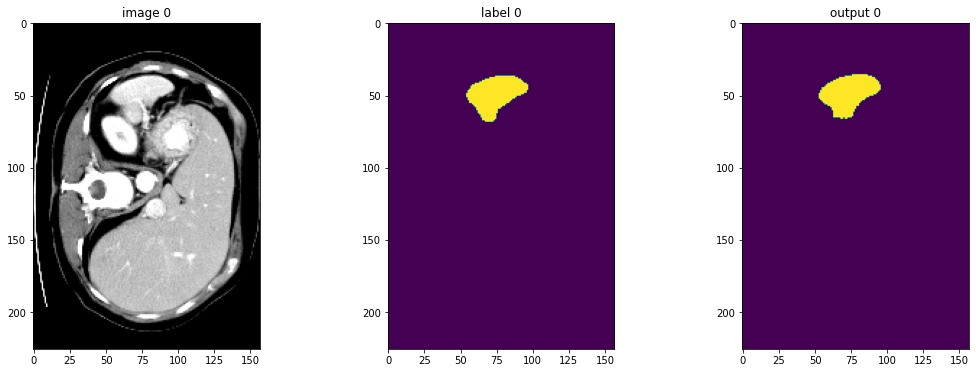

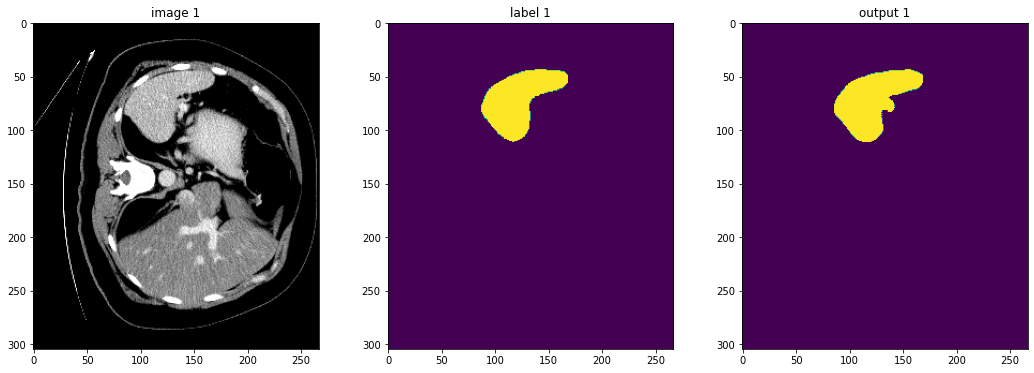

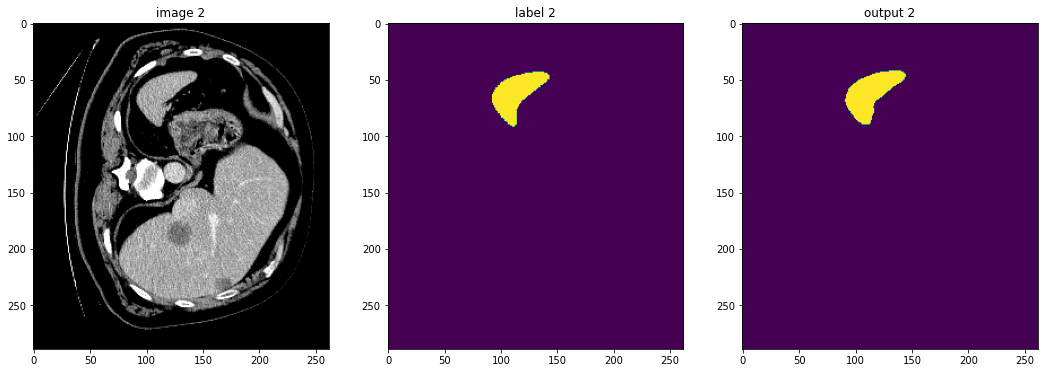

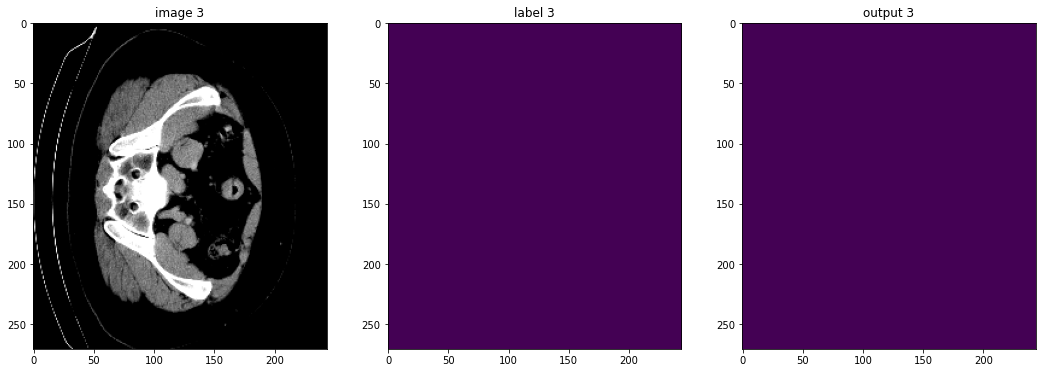

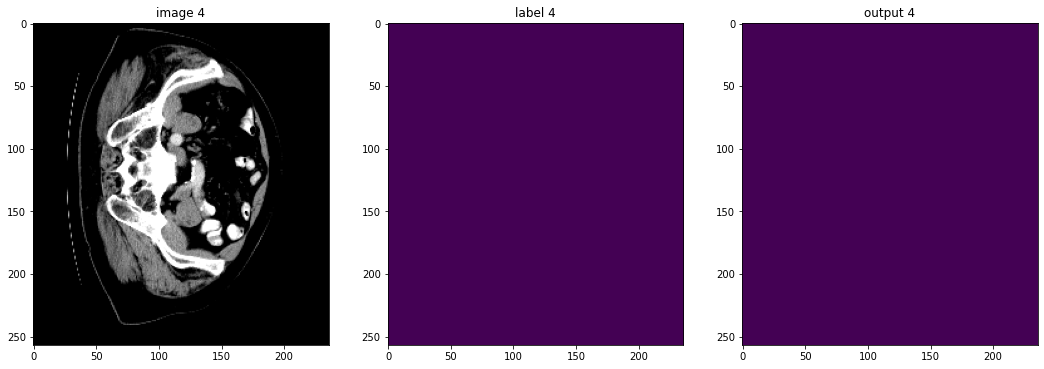

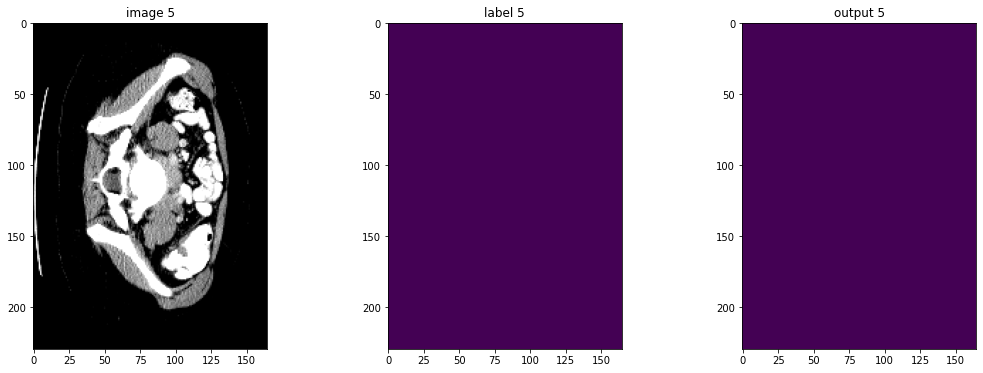

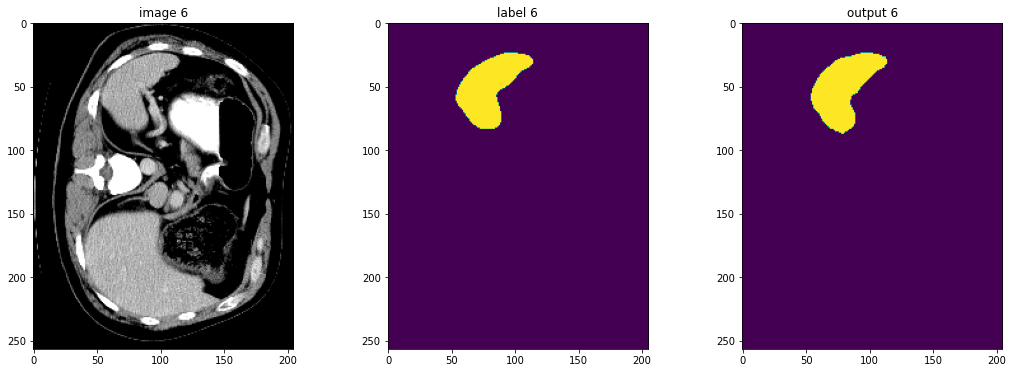

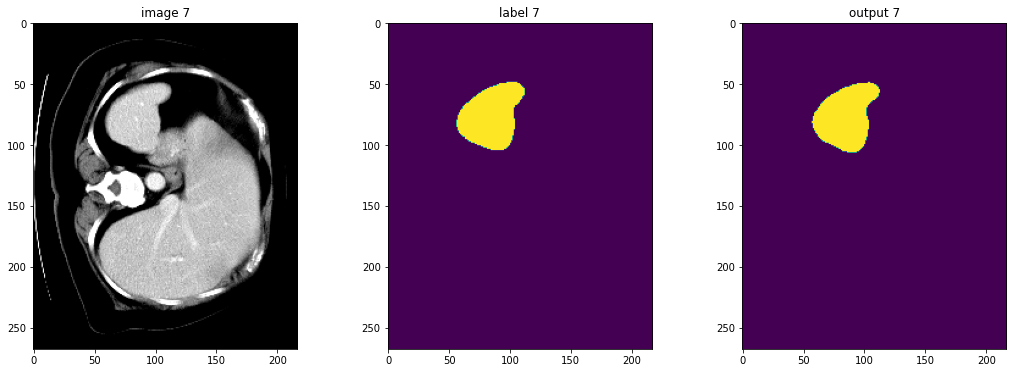

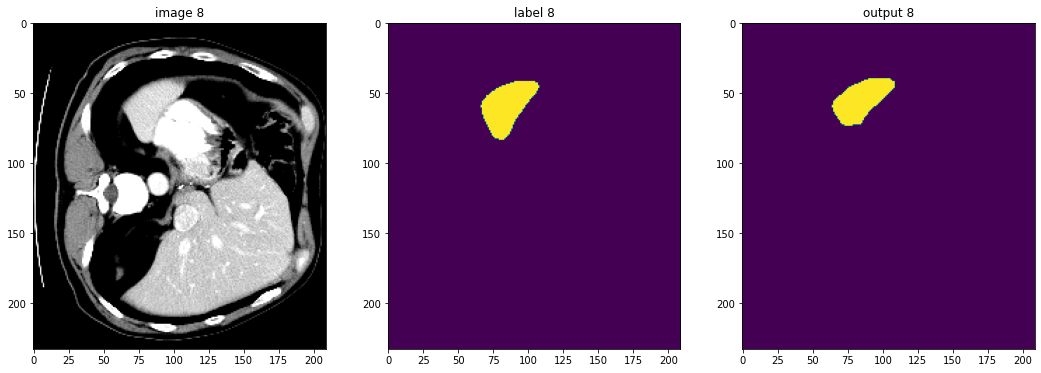

In [9]:
net.eval()
device = torch.device("cuda:0")
net.to(device)
with torch.no_grad():
    for i, val_data in enumerate(net.val_dataloader()):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, net
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()

**Evaluation with other Dataset**

In [16]:
images = sorted(glob(os.path.join(data_dir, "imagesTr", "Spleen_104.nii.gz")))
labels = sorted(glob(os.path.join(data_dir, "labelsTr", "Spleen_104.nii.gz")))
test = [{"image": image_name, "label": label_name}
            for image_name, label_name in zip(images, labels)]
val_transforms = Compose(
            [
                LoadImaged(keys=["image", "label"]),
                AddChanneld(keys=["image", "label"]),
                Spacingd(
                    keys=["image", "label"],
                    pixdim=(1.5, 1.5, 2.0),
                    mode=("bilinear", "nearest"),
                ),
                Orientationd(keys=["image", "label"], axcodes="RAS"),
                ScaleIntensityRanged(
                    keys=["image"], a_min=-57, a_max=164,
                    b_min=0.0, b_max=1.0, clip=True,
                ),
                CropForegroundd(keys=["image", "label"], source_key="image"),
                ToTensord(keys=["image", "label"]),
            ]
        ) 
val_ds = CacheDataset(
            data=test, transform=val_transforms,
            cache_rate=1.0, num_workers=4,
        )
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=1, num_workers=4)
from monai.metrics import DiceMetric
from monai.transforms import Activations, AddChannel, AsDiscrete, Compose, ScaleIntensity, ToTensor
dice_metric = DiceMetric(include_background=True, reduction="mean")
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold_values=True)])



100%|██████████| 1/1 [00:04<00:00,  4.99s/it]


val_dice: tensor([[0.9392]], device='cuda:0')
Confusion Matrix: tensor([[[5.2752e+04, 3.6370e+03, 1.5660e+07, 3.1900e+03]]], device='cuda:0')
Hausdorff: tensor([[178.9106]], dtype=torch.float64)
Shape: torch.Size([1, 1, 258, 238, 256])
voxels: [tensor(15719046, device='cuda:0')]


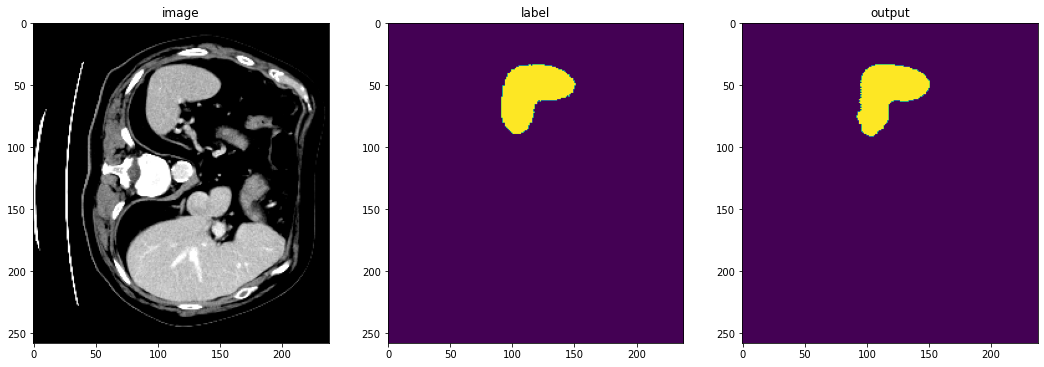

evaluation metric: 0.9392242431640625


In [23]:
from monai.metrics import get_confusion_matrix, compute_hausdorff_distance
device = torch.device("cuda:0")
model =     UNet(
            dimensions=3,
            in_channels=1,
            out_channels=2,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2,
            ).to(device)
#loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
device = torch.device("cuda:0")
model.load_state_dict(torch.load("/content/drive/My Drive/Task09_Spleen/best_metric_model_21.pth"))
model.eval()
model.to(device)
with torch.no_grad():
        metric_sum = 0.0
        metric_count = 0
        #saver = NiftiSaver(output_dir="./output")
        for val_data in val_loader:
            # define sliding window size and batch size for windows inference
            val_images, val_labels = val_data["image"].to(device), val_data["label"].to(device)
            roi_size = (96, 96, 96)
            sw_batch_size = 4
            val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
            val_outputs = post_trans(val_outputs)
            shape=val_images.shape
            vols = [(b==1).sum() for b in val_outputs]
            value = compute_meandice(
            y_pred=val_outputs,
            y=val_labels,
            include_background=False)
          
            conf = get_confusion_matrix(y_pred=val_outputs, y=val_labels, include_background=False)
            hausdorff = compute_hausdorff_distance(y_pred=val_outputs, y=val_labels, include_background=False)
            metric_count += len(value)
            metric_sum += value.item() * len(value)
            #print(f"val_loss:", loss)
            print(f"val_dice:", value)
            print(f"Confusion Matrix:", conf)
            print(f"Hausdorff:",hausdorff)
            print(f"Shape:", shape)
            print(f"voxels:", vols)
            #print(f"y_pred:",val_outputs)
            #print(f"y:", val_labels)
            plt.figure("check", (18, 6))
            plt.subplot(1, 3, 1)
            plt.title(f"image")
            plt.imshow(val_data["image"][0, 0, :, :, 200], cmap="gray")
            plt.subplot(1, 3, 2)
            plt.title(f"label")
            plt.imshow(val_data["label"][0, 0, :, :, 200])
            plt.subplot(1, 3, 3)
            plt.title(f"output")
            plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 200])
            plt.show()
        metric = metric_sum / metric_count
        print("evaluation metric:", metric)